# Comparing Performance for Memory-Based SR Algs

In this notebook, the agent is trained starting in random positions to navigate from the top-left to the bottom-right of an open field. The agent operates a softmax policy with $\beta = 5$. At test time, the agent acts greedily according to its Q-function, computed as the product of its SR and its state-based reward weights learned at the training time. We compare the average episode run across a number of episodes.

Three different training algorithms are used: SR-SARSA, SR-Dyna, and SR-PS. Each is trained with the same number of episodes, and SR-Dyna and SR-PS additionally use the same number of memory iterations. We also provide visualizations of which states were most frequently recalled for both SR-Dyna and SR-PS.

In [1]:
import numpy as np
import numpy.random as npr
from gridworld import SimpleGrid
from algs import TDSR
import progressbar
from plotting import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import exp_normalize, memory_update, get_dyna_indices, get_predecessors, queue_append

npr.seed(0)

In [2]:
grid_size = 7
pattern="empty" # "empty" or "four_rooms" or "random"
env = SimpleGrid(grid_size, block_pattern=pattern, obs_mode="index")

In [3]:
# env episode params
episode_length = (4 * grid_size)
episodes_train = 50
episodes_test  = 10
agent_pos = [0, 0]
goal_pos = [grid_size -1, grid_size -1]

# all agent params
gamma = 0.99
lr = 1e-1 # learning rate across all incremental algs
poltype = 'softmax' # "egreedy" or "softmax"
epsilon = 1 # for epsilon-greedy policies
beta = 5 # inverse temperature for softmax policies

# memory params
n_mem = 6 # number of retrieved memories per timestep
theta = 5e-1 # priority threshold for prioritized sweeping

## Training Phase

### No Memory

In [4]:
agent_nomem = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
errors = []

for i in progressbar.progressbar(range(episodes_train)):
    
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_nomem.sample_action(state, epsilon=epsilon, beta=beta)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
        
        if (j > 1):
            td_sr = agent_nomem.update_sr(experiences[-2], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            td_w = agent_nomem.update_w(experiences[-1])
                         
        if env.done:
            td_sr = agent_nomem.update_sr(experiences[-1], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
                        
        if env.done:
            break

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


### Dyna

In [5]:
agent_dyna = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
exp_weights = []
errors = []
prioritized_states = np.zeros(env.state_size)

for i in progressbar.progressbar(range(episodes_train)):
    
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_dyna.sample_action(state, epsilon=epsilon, beta=beta)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
        
        if (j > 1):
            td_sr = agent_dyna.update_sr(experiences[-2], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            td_w = agent_dyna.update_w(experiences[-1])
                         
        if env.done:
            td_sr = agent_dyna.update_sr(experiences[-1], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            
        exp_weights.append(len(experiences))
        mem_indices = get_dyna_indices(experiences, exp_weights, n_mem)
        mem = [experiences[t] for t in mem_indices]
        for exp in mem:
            prioritized_states[exp[0]] += 1
            td_sr = memory_update(exp, agent_dyna, epsilon, beta)
            grad = agent_dyna.update_eigs(exp)
                        
        if env.done:
            break

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


### Visualize Prioritized States

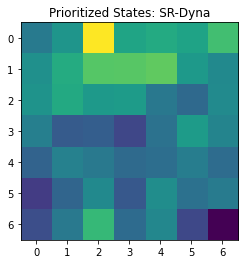

In [6]:
cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap.set_bad(color="white")
plt.imshow(utils.mask_grid(prioritized_states.reshape(grid_size, grid_size), env.blocks), cmap=cmap);
plt.title('Prioritized States: SR-Dyna');

### Prioritized Sweeping

In [7]:
agent_ps = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
pqueue = []
errors = []
prioritized_states = np.zeros(env.state_size)

for i in progressbar.progressbar(range(episodes_train)):
    
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_ps.sample_action(state, epsilon=epsilon, beta=beta)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
        
        if (j > 1):
            td_sr = agent_ps.update_sr(experiences[-2], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            if (np.linalg.norm(td_sr) > theta):
                pqueue = queue_append(experiences[-2], np.linalg.norm(td_sr), pqueue)
            td_w = agent_ps.update_w(experiences[-1])
                         
        if env.done:
            td_sr = agent_ps.update_sr(experiences[-1], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            if (np.linalg.norm(td_sr) > theta):
                pqueue = queue_append(experiences[-1], np.linalg.norm(td_sr), pqueue)
            
        for k in range(n_mem):
            
#             pqueue = pqueue[-100:]

            if not pqueue:
                break

            # get highest priority item and remove
            pqueue = sorted(pqueue, key = lambda item: item["priority"])
            exp = pqueue.pop()["exp"]
            
            prioritized_states[exp[0]] += 1

            td_sr = memory_update(exp, agent_ps, epsilon, beta)                
            grad = agent_ps.update_eigs(exp)

            for exp_pred in get_predecessors(exp[0], experiences):
                td_sr = memory_update(exp_pred, agent_ps, epsilon, beta)                    
                if (np.linalg.norm(td_sr) > theta):
                    pqueue = queue_append(exp_pred, np.linalg.norm(td_sr), pqueue)
                        
        if env.done:
            break

100% (50 of 50) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


### Visualize Prioritized States

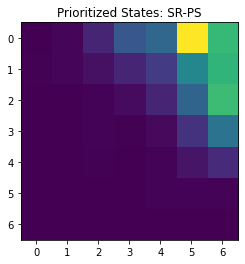

In [8]:
cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap.set_bad(color="white")
plt.imshow(utils.mask_grid(prioritized_states.reshape(grid_size, grid_size), env.blocks), cmap=cmap);
plt.title('Prioritized States: SR-PS');

## Test Phase

In [9]:
# set agents to act according to their learned Q-functions
for agent in [agent_nomem, agent_dyna, agent_ps]:
    agent.poltype = 'egreedy'

epsilon = 0.

In [10]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_nomem.sample_action(state, epsilon=epsilon, beta=beta)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
            
    ep_lengths.append(len(experiences))
            
av_ep_length_nomem = np.mean(ep_lengths)

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [11]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_dyna.sample_action(state, epsilon=epsilon, beta=beta)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
        
    ep_lengths.append(len(experiences))
            
av_ep_length_dyna = np.mean(ep_lengths)

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [12]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_ps.sample_action(state, epsilon=epsilon, beta=beta)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
            
    ep_lengths.append(len(experiences))
            
av_ep_length_ps = np.mean(ep_lengths)

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


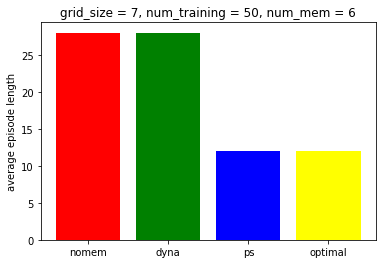

In [13]:
color = ['red', 'green', 'blue', 'yellow']
plt.bar(['nomem', 'dyna', 'ps', 'optimal'], [av_ep_length_nomem, av_ep_length_dyna, av_ep_length_ps, 2 * (grid_size - 1)], color=color);
plt.title(f'grid_size = {grid_size}, num_training = {episodes_train}, num_mem = {n_mem}');
plt.ylabel('average episode length');